In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import head_direction.head as head
import spatial_maps as sp
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from distutils.dir_util import copy_tree
from neo import SpikeTrain
import scipy

from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()


from spike_statistics.core import permutation_resampling_test, block_bootstrap

from spikewaveform.core import calculate_waveform_features_from_template, cluster_waveform_features

from septum_mec.analysis.plotting import violinplot, despine

15:16:43 [I] klustakwik KlustaKwik2 version 0.2.6


In [3]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})

output_path = pathlib.Path("output") / "stimulus-spike-lfp-response-other-tetrode"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)
output_path.mkdir(exist_ok=True)

In [4]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [5]:
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')

In [6]:
lfp_action = actions['stimulus-spike-lfp-response-other-tetrode']
lfp_results = pd.read_csv(lfp_action.data_path('results'))

In [7]:
# lfp_results has old unit id's but correct on (action, unit_name, channel_group)
lfp_results = lfp_results.drop('unit_id', axis=1)

In [8]:
stim_action = actions['stimulus-response']
stim_results = pd.read_csv(stim_action.data_path('results'))

In [9]:
# lfp_results has old unit id's but correct on (action, unit_name, channel_group)
# stim_results = stim_results.drop('unit_id', axis=1)

In [10]:
statistics_action = actions['calculate-statistics']
shuffling = actions['shuffling']

statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics_results = session_units.merge(statistics_results, how='left')
quantiles_95 = pd.read_csv(shuffling.data_path('quantiles_95'))
action_columns = ['action', 'channel_group', 'unit_name']
data = pd.merge(statistics_results, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

In [11]:
data['unit_day'] = data.apply(lambda x: str(x.unit_idnum) + '_' + x.action.split('-')[1], axis=1)

In [12]:
data = data.merge(lfp_results, how='left')

In [13]:
data = data.merge(stim_results, how='left')

In [14]:
waveform_action = actions['waveform-analysis']
waveform_results = pd.read_csv(waveform_action.data_path('results')).drop('template', axis=1)

In [15]:
data = data.merge(waveform_results, how='left')

In [16]:
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']
labels = ['Baseline I', '11 Hz', 'Baseline II', '30 Hz']
queries = ['baseline and i and Hz11', 'frequency==11', 'baseline and ii and Hz30', 'frequency==30']

In [17]:
data.bs = data.bs.astype(bool)

In [18]:
data.loc[data.eval('t_i_peak == t_i_peak and not bs'), 'ns_inhibited'] = True
data.ns_inhibited.fillna(False, inplace=True)

data.loc[data.eval('t_i_peak != t_i_peak and not bs'), 'ns_not_inhibited'] = True
data.ns_not_inhibited.fillna(False, inplace=True)

In [19]:
# make baseline for inhibited vs not inhibited
data.loc[data.unit_id.isin(data.query('ns_inhibited').unit_id.values), 'ns_inhibited'] = True
data.loc[data.unit_id.isin(data.query('ns_not_inhibited').unit_id.values), 'ns_not_inhibited'] = True

In [20]:
query = (
    'gridness > gridness_threshold and '
    'information_rate > information_rate_threshold and '
    'gridness > .2 and '
    'average_rate < 25'
)
sessions_above_threshold = data.query(query)
print("Number of sessions above threshold", len(sessions_above_threshold))
print("Number of animals", len(sessions_above_threshold.groupby(['entity'])))

Number of sessions above threshold 194
Number of animals 4


In [21]:
gridcell_sessions = data[data.unit_day.isin(sessions_above_threshold.unit_day.values)]
print("Number of gridcells", gridcell_sessions.unit_idnum.nunique())
print("Number of gridcell recordings", len(gridcell_sessions))
print("Number of animals", len(gridcell_sessions.groupby(['entity'])))

Number of gridcells 139
Number of gridcell recordings 230
Number of animals 4


In [22]:
gridcell_sessions

action  baseline  entity  frequency      i     ii  session  \
14    1839-120619-4     False    1839       30.0  False   True        4   
21    1839-120619-4     False    1839       30.0  False   True        4   
29    1839-120619-4     False    1839       30.0  False   True        4   
30    1839-120619-4     False    1839       30.0  False   True        4   
31    1839-120619-4     False    1839       30.0  False   True        4   
...             ...       ...     ...        ...    ...    ...      ...   
1263  1833-010719-2     False    1833       11.0   True  False        2   
1264  1833-010719-2     False    1833       11.0   True  False        2   
1268  1833-010719-2     False    1833       11.0   True  False        2   
1271  1833-010719-2     False    1833       11.0   True  False        2   
1275  1833-010719-2     False    1833       11.0   True  False        2   

     stim_location  stimulated      tag  ...  t_i_peak  p_i_peak  half_width  \
14              ms        True  stim ii  ...    0.0087  0.000055    0.259757   
21              ms        True  stim ii  ...    0.0008  0.000880    0.242524   
29              ms        True  stim ii  ...       NaN       NaN    0.279806   
30              ms        True  stim ii  ...    0.0005  0.002365    0.265158   
31              ms        True  stim ii  ...       NaN       NaN    0.246920   
...            ...         ...      ...  ...       ...       ...         ...   
1263            ms        True   stim i  ...       NaN       NaN    0.280033   
1264            ms        True   stim i  ...       NaN       NaN    0.281934   
1268            ms        True   stim i  ...       NaN       NaN    0.266512   
1271            ms        True   stim i  ...       NaN       NaN    0.223261   
1275            ms        True   stim i  ...       NaN       NaN    0.257098   

      peak_to_trough  average_firing_rate     bs  bs_stim bs_ctrl  \
14          0.362390             0.180529  False      0.0     NaN   
21          0.534827             2.265039   True      1.0     NaN   
29          0.598967            10.924422   True      1.0     NaN   
30          0.581451             3.984881   True      1.0     NaN   
31          0.570844             3.497452   True      1.0     NaN   
...              ...                  ...    ...      ...     ...   
1263        0.560729             4.760330   True      1.0     NaN   
1264        0.627089            15.890929   True      1.0     NaN   
1268        0.594033             2.704037   True      1.0     NaN   
1271        0.592553             9.658453   True      1.0     NaN   
1275        0.545188             5.292658   True      1.0     NaN   

      ns_inhibited  ns_not_inhibited  
14            True             False  
21           False             False  
29           False             False  
30           False             False  
31           False             False  
...            ...               ...  
1263         False             False  
1264         False             False  
1268         False             False  
1271         False             False  
1275         False             False  

[230 rows x 78 columns]

In [23]:
data.loc[:,'gridcell'] = np.nan
data['gridcell'] = data.isin(gridcell_sessions)

data.loc[data.eval('not gridcell and bs'), 'bs_not_gridcell'] = True
data.bs_not_gridcell.fillna(False, inplace=True)

In [24]:
data.query('baseline and Hz11 and gridcell').head()

action  baseline  entity  frequency     i     ii  session  \
33  1833-260619-1      True    1833        NaN  True  False        1   
34  1833-260619-1      True    1833        NaN  True  False        1   
35  1833-260619-1      True    1833        NaN  True  False        1   
39  1833-260619-1      True    1833        NaN  True  False        1   
40  1833-260619-1      True    1833        NaN  True  False        1   

   stim_location  stimulated         tag  ...  half_width peak_to_trough  \
33           NaN       False  baseline i  ...    0.272875       0.602667   
34           NaN       False  baseline i  ...    0.226452       0.274814   
35           NaN       False  baseline i  ...    0.247266       0.570104   
39           NaN       False  baseline i  ...    0.284542       0.644111   
40           NaN       False  baseline i  ...    0.259920       0.581698   

    average_firing_rate     bs  bs_stim  bs_ctrl  ns_inhibited  \
33             5.945508   True      NaN      1.0         False   
34             2.860048  False      NaN      0.0         False   
35             3.365674   True      NaN      1.0         False   
39            17.471520   True      NaN      1.0         False   
40             5.891739   True      NaN      1.0         False   

   ns_not_inhibited  gridcell  bs_not_gridcell  
33            False      True            False  
34             True      True            False  
35            False      True            False  
39            False      True            False  
40            False      True            False  

[5 rows x 80 columns]

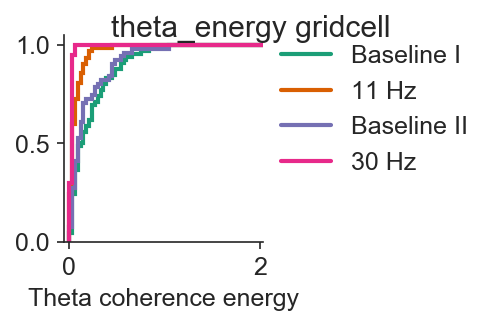

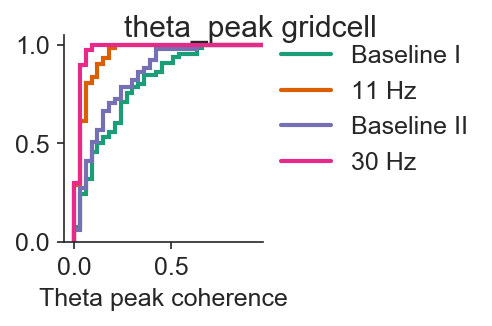

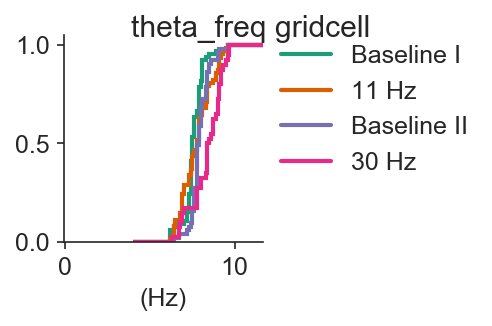

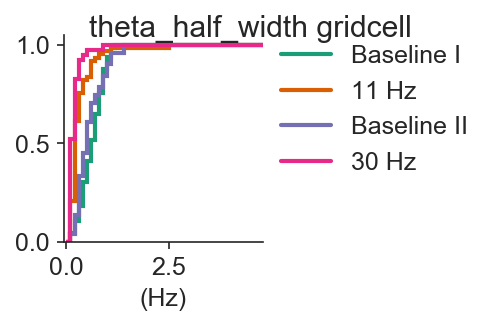

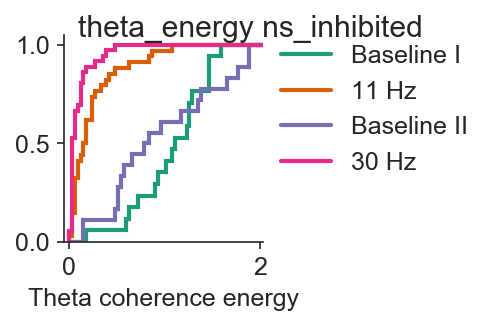

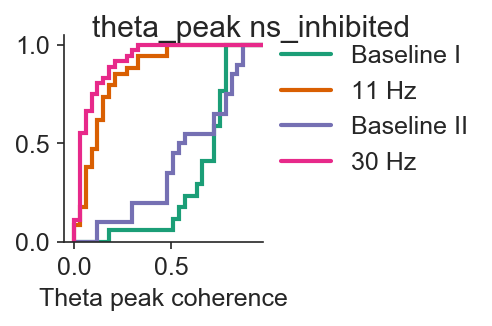

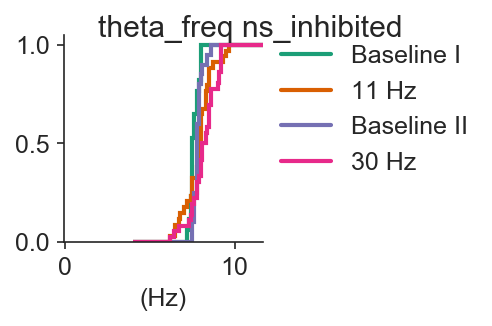

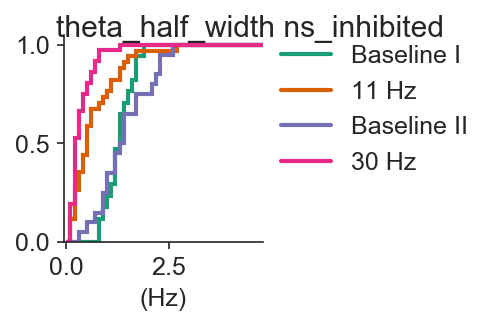

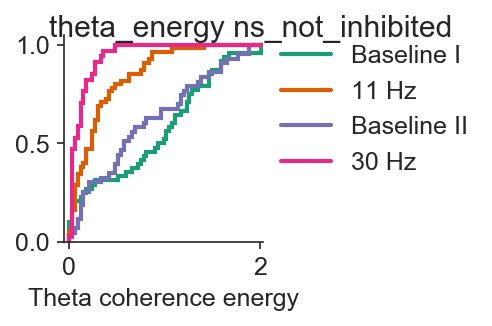

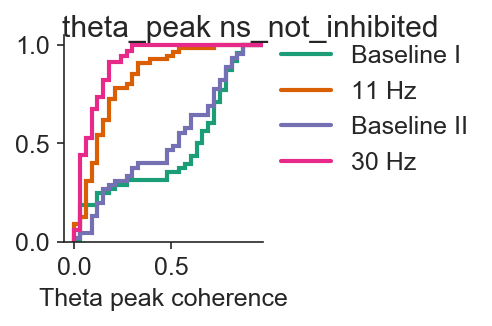

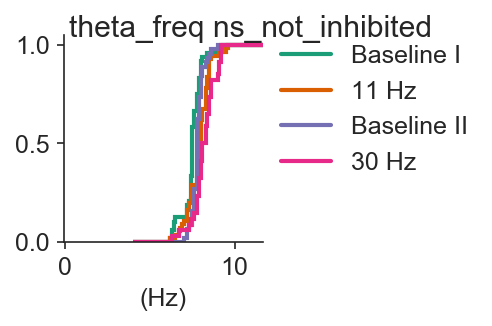

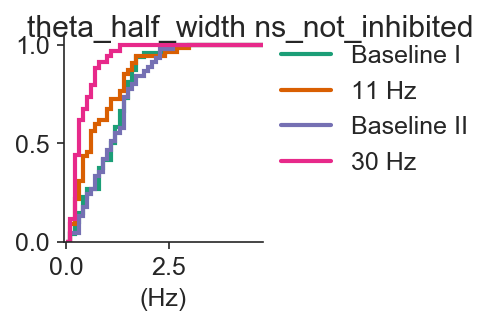

In [25]:

density = True
cumulative = True
histtype = 'step'
lw = 2
bins = {
    'theta_energy': np.arange(0, 2.1, .03),
    'theta_peak': np.arange(0, 1, .03),
    'theta_freq': np.arange(4, 12, .1),
    'theta_half_width': np.arange(0, 5, .1)
}
xlabel = {
    'theta_energy': 'Theta coherence energy',
    'theta_peak': 'Theta peak coherence',
    'theta_freq': '(Hz)',
    'theta_half_width': '(Hz)',
}
for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    for key in bins:
        fig = plt.figure(figsize=(3.5,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, query, label in zip(colors, queries, labels):
            values = data.query(query + ' and ' + cell_type)[key]
            values.hist(
                bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
                histtype=histtype, color=color)
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, lw=lw, label=label))
        plt.xlabel(xlabel[key])
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
        plt.grid(False)
        plt.xlim(-0.05, bins[key].max() - bins[key].max()*0.02)
        despine()
        figname = f'spike-lfp-coherence-histogram-{key}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

In [26]:
data['stim_strength'] = data.stim_p_max / data.theta_peak

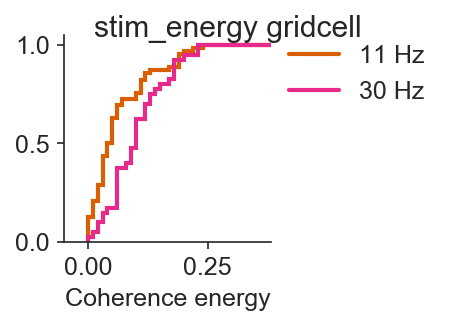

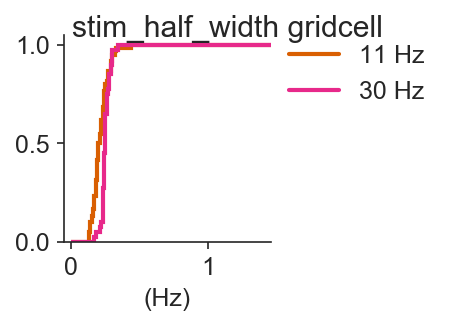

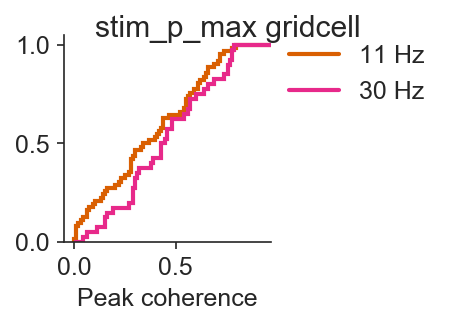

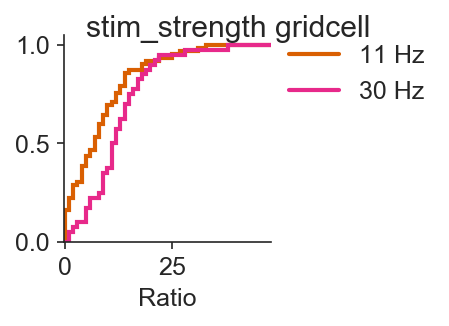

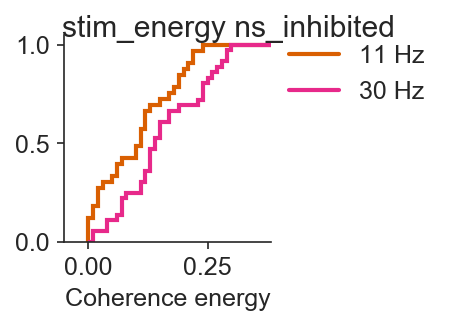

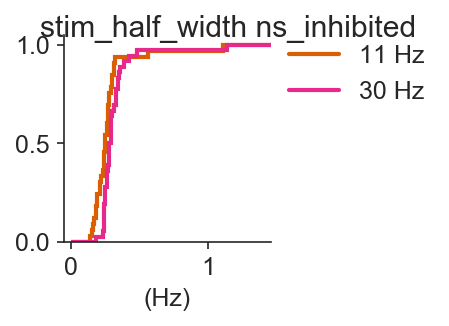

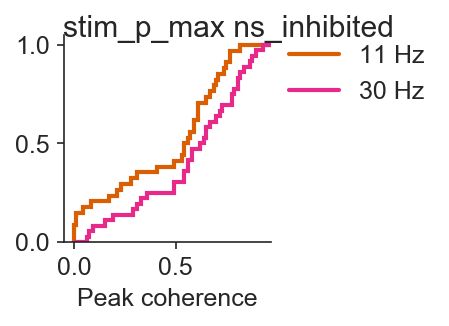

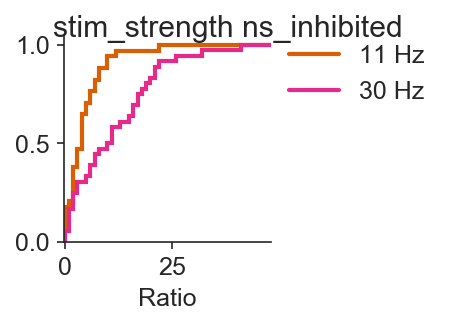

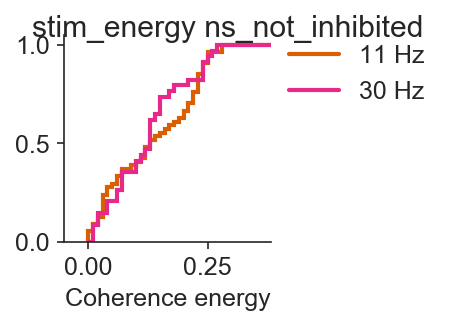

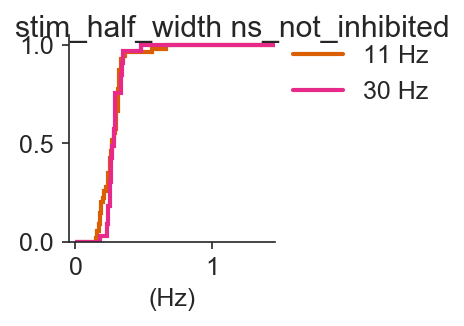

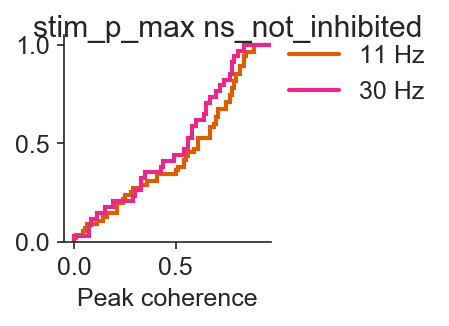

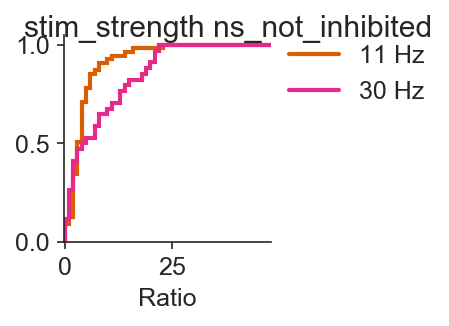

In [27]:

density = True
cumulative = True
histtype = 'step'
lw = 2
bins = {
    'stim_energy': np.arange(0, .4, .01),
    'stim_half_width': np.arange(0, 1.5, .01),
    'stim_p_max': np.arange(0, 1, .01),
    'stim_strength': np.arange(0, 50, 1)
}
xlabel = {
    'stim_energy': 'Coherence energy',
    'stim_half_width': '(Hz)',
    'stim_p_max': 'Peak coherence',
    'stim_strength': 'Ratio',
}
# key = 'theta_energy'
# key = 'theta_peak'
for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    for key in bins:
        fig = plt.figure(figsize=(3.2,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, query, label in zip(colors[1::2], queries[1::2], labels[1::2]):
            values = data.query(query + ' and ' + cell_type)[key]
            values.hist(
                bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
                histtype=histtype, color=color)
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, lw=lw, label=label))
        plt.xlabel(xlabel[key])
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
        plt.grid(False)
        plt.xlim(-0.05, bins[key].max() - bins[key].max()*0.02)
        despine()
        figname = f'spike-lfp-coherence-histogram-{key}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

# stats

In [28]:
keys = [
    'theta_energy',
    'theta_peak',
    'theta_freq',
    'theta_half_width',
    'stim_energy',
    'stim_half_width',
    'stim_p_max',
    'stim_strength'
]
cell_types = [
    'gridcell', 
    'ns_inhibited', 
    'ns_not_inhibited'
]
results = {}
for cell_type in cell_types:
    results[cell_type] = {}
    for key in keys:
        results[cell_type][key] = list()
        for query, label in zip(queries, labels):
            values = data.query(query + ' and ' + cell_type).loc[:,['entity', 'unit_idnum', 'date', key]]
            results[cell_type][key].append(values.rename({key: label}, axis=1))

In [29]:
from functools import reduce

In [30]:
for cell_type, cell_type_val in results.items():
    for key, val in cell_type_val.items():
        df = reduce(lambda  left, right: pd.merge(left, right, on=['entity', 'unit_idnum', 'date'], how='outer'), val)
        results[cell_type][key] = df#.drop('unit_day',axis=1)

In [31]:
results['gridcell']['theta_energy']

entity  unit_idnum    date  Baseline I     11 Hz  Baseline II     30 Hz
0      1833          30  260619    0.041406       NaN     0.298463       NaN
1      1833          31  260619    0.061501       NaN     0.142262  0.032669
2      1833          32  260619    0.041564  0.025491     0.059868  0.019647
3      1833          78  260619    0.056602       NaN          NaN       NaN
4      1833          79  260619    0.051091  0.106032          NaN       NaN
..      ...         ...     ...         ...       ...          ...       ...
146    1833         249  120619         NaN       NaN          NaN  0.057042
147    1833         218  290519         NaN       NaN          NaN  0.060762
148    1833         106   60619         NaN       NaN          NaN  0.045159
149    1833         168   60619         NaN       NaN          NaN  0.033186
150    1833         233   60619         NaN       NaN          NaN  0.043358

[151 rows x 7 columns]

In [32]:
# var = results['gridcell']['theta_energy']

In [33]:
# baseline_i = [var.query(f'entity=="{entity}"').loc[:,'Baseline I'].rename(entity).dropna().values for entity in var.entity.unique()]
# stim_11 = [var.query(f'entity=="{entity}"').loc[:,'11 Hz'].rename(entity).dropna().values for entity in var.entity.unique()]

In [34]:
# boot_baseline_i = block_bootstrap(baseline_i, n_boots=1000, statistic=np.mean)
# boot_stim_11 = block_bootstrap(stim_11, n_boots=1000, statistic=np.mean)
# pval, observed_diff = permutation_resampling(np.ravel(boot_cases), np.ravel(boot_controls), n_samples=1000, statistic=np.mean)
    
#     Uvalue, pval = scipy.stats.mannwhitneyu(
#         np.ravel(boot_cases), 
#         np.ravel(boot_controls),
#         alternative='two-sided')

#     boot_cases = block_bootstrap(case, n_boots=n_boots, statistic=statistic)
#     boot_controls = block_bootstrap(control, n_boots=n_boots, statistic=statistic)
#     pval, observed_diff = compute_direct_prob(np.ravel(boot_cases), np.ravel(boot_controls))

In [35]:
# TODO
# eksempel polarplot av phase precessing celle
# populasjon vector length tall test
# cumulative vector length plot bytter ut coherence peak
# ta vekk baseline i vs 30 hz violin plot

In [36]:
bootstrap_results = {}
for cell_type in results:
    bootstrap_results[cell_type] = {}
    for key, df in results[cell_type].items():
        bootstrap_results[cell_type][key] = pd.DataFrame()
        group = df.groupby('entity')
        for label in labels:
            tmp = [d.loc[:, label].dropna().values for _, d in group]
            if all(len(a) == 0 for a in tmp):
                boot_samples = np.ones(100) * np.nan
#                 boot_samples = np.ones(4000) * np.nan
            elif any(len(a) == 0 for a in tmp):
                idx = [i for i, a in enumerate(tmp) if len(a) == 0]
                for i in idx:
                    del tmp[i]
            else:
                boot_samples = block_bootstrap(tmp, n_boots=100, n_samples=10, n_blocks=4, statistic=np.mean)
#                 boot_samples = block_bootstrap(tmp, n_boots=100, n_samples=10, n_blocks=4)
#             print(np.ravel(boot_samples).shape)
            bootstrap_results[cell_type][key].loc[:, label] = np.ravel(boot_samples)

In [37]:
bootstrap_results['gridcell']['theta_energy']

Baseline I     11 Hz  Baseline II     30 Hz
0     0.258000  0.068413     0.325751  0.038687
1     0.246690  0.064067     0.211732  0.038816
2     0.192637  0.120363     0.213316  0.038773
3     0.221004  0.090627     0.271908  0.037142
4     0.295930  0.103089     0.254053  0.038291
..         ...       ...          ...       ...
95    0.194709  0.096495     0.187678  0.039749
96    0.313481  0.074361     0.424475  0.035929
97    0.229241  0.083616     0.293086  0.039822
98    0.233260  0.110227     0.233062  0.038597
99    0.283064  0.123371     0.250309  0.038475

[100 rows x 4 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96954caf28>,
      dtype=object)

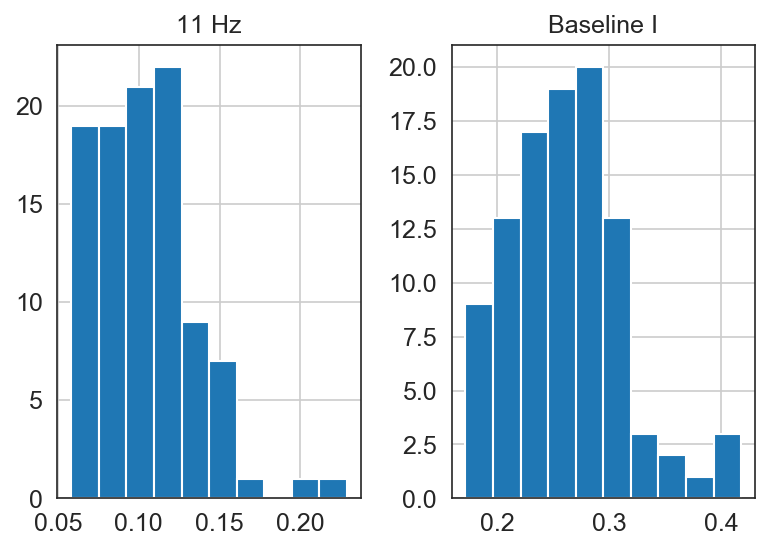

In [38]:
bootstrap_results['gridcell']['theta_energy'].loc[:,['Baseline I', '11 Hz']].hist()

In [39]:
ll, hh = [], []
for _ in range(1000):
    a = np.random.random(10000)
    stat = np.sort(a)
    alpha = 0.05
    n = len(stat)
    low = stat[int((alpha / 2.0) * n)]
    high = stat[int((1 - alpha / 2.0) * n)]
    l, h = np.percentile(a, [2.5, 97.5])
    ll = abs(low - l)
    hh = abs(high - h)

In [40]:
np.mean(ll), np.mean(hh)

(3.672187483799022e-06, 0.00016742309740980232)

In [41]:
def compute_weighted_mean_sem(data, label):
    group = data.groupby('entity')
    tmp = [d.loc[:, label].dropna().values for _, d in group]
    values = np.concatenate(tmp)
    if len(values) == 0:
        return [np.nan] * 3
    weights = np.concatenate([np.ones_like(a) / len(a) for a in tmp])
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values - average)**2, weights=weights)
    sem = np.sqrt(variance / len(values))
    return average, sem, len(values)


def compute_confidence_interval(data, alpha=0.05):
    stat = np.sort(data.dropna())
    n = len(stat)
    if n == 0:
        return np.nan, np.nan
    low = stat[int((alpha / 2.0) * n)]
    high = stat[int((1 - alpha / 2.0) * n)]
#     low, high = np.percentile(data.dropna(), [(alpha / 2.0) * 100, (1 - alpha / 2.0) * 100])
    return low, high


def pvalue(df, df_bootstrap, control_key, case_key):
    '''
    pvalue
    '''
    case, b = df_bootstrap[case_key].dropna(), df_bootstrap[control_key].dropna()
    if len(case) == 0 or len(b) == 0:
        return np.nan
    
    n = len(case)
    
    average_case, _, _ = compute_weighted_mean_sem(df, case_key)
    average_control, _, _ = compute_weighted_mean_sem(df, control_key)
    
    low, high = compute_confidence_interval(case - average_control)
    
    case = case - case.mean() + average_control
    diff = abs(average_case - average_control)    
    
    pval = (np.sum(case > average_control + diff) + np.sum(case < average_control - diff)) / n
    
    return "{:.1e} [{:.2f}, {:.2f}]".format(pval, low, high)


def rename(name):
    return name.replace("_field", "-field").replace("_", " ").capitalize()

In [42]:
stats = {}
for cell_type in bootstrap_results:
    stat = pd.DataFrame()

    for key, df in bootstrap_results[cell_type].items():
        Key = rename(key)
        
        for label in labels:
#             low, high = compute_confidence_interval(df.loc[:,label])
#             average, _, n = compute_weighted_mean_sem(results[cell_type][key], label)
#             stat.loc[label, Key] = "{:.2f} [{:.2f}, {:.2f}] ({})".format(average, low, high, n)
            average, sem, n = compute_weighted_mean_sem(results[cell_type][key], label)
            if np.isnan(average):
                stat.loc[label, Key] = np.nan
            else:
                stat.loc[label, Key] = "{:.2f} ± {:.2f} ({})".format(average, sem, n)

        for i, c1 in enumerate(df.columns):
            for c2 in df.columns[i+1:]:
#                 stat.loc[f'probability {c1} {c2}', Key] = probability(df, [c1, c2])
#                 stat.loc[f'{c1} - {c2}', Key] = pvalue(df, c1, c2)
                stat.loc[f'{c1} - {c2}', Key] = pvalue2(results[cell_type][key], df, c1, c2)

    stats[cell_type] = stat

NameError: name 'pvalue2' is not defined

In [ ]:
bootstrap_results['gridcell']['theta_energy'].loc[:,'Baseline I'].mean(), bootstrap_results['gridcell']['theta_energy'].loc[:,'Baseline I'].std()

In [ ]:
stats['gridcell']

In [ ]:
def summarize(data):
    return "{:.2f} ± {:.2f} ({})".format(data.mean(), data.sem(), sum(~np.isnan(data)))


def MWU(df, keys):
    '''
    Mann Whitney U
    '''
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        df[keys[0]].dropna(), 
        df[keys[1]].dropna(),
        alternative='two-sided')

    return "{:.2f}, {:.3f}".format(Uvalue, pvalue)


def PRS(df, keys):
    '''
    Permutation ReSampling
    '''
    pvalue, observed_diff, diffs = permutation_resampling_test(
        df[keys[0]].dropna(), 
        df[keys[1]].dropna(), statistic=np.median)

    return "{:.2f}, {:.3f}".format(observed_diff, pvalue)


def normality(df, key):
    statistic, pvalue = scipy.stats.normaltest(
        df[key].dropna())

    return "{:.2f}, {:.3f}".format(statistic, pvalue)


def rename(name):
    return name.replace("_field", "-field").replace("_", " ").capitalize()

In [ ]:
stats = {}
for cell_type in bootstrap_results:
    stat = pd.DataFrame()

    for key, df in bootstrap_results[cell_type].items():
        Key = rename(key)
        stat[Key] = df.agg(summarize)
#         stat[Key] = df.agg(summarize)

        for i, c1 in enumerate(df.columns):
            if len(df[c1].dropna()) < 8:
                stat.loc[f'Normality {c1}', Key] = np.nan
            else:
                stat.loc[f'Normality {c1}', Key] = normality(df, c1)
            for c2 in df.columns[i+1:]:
                stat.loc[f'MWU {c1} {c2}', Key] = MWU(df, [c1, c2])
                stat.loc[f'PRS {c1} {c2}', Key] = PRS(df, [c1, c2])

    stats[cell_type] = stat

In [ ]:
stats['gridcell']

In [ ]:
for cell_type, stat in stats.items():
    stat.to_latex(output_path / "statistics" / f"statistics_{cell_type}.tex")
    stat.to_csv(output_path / "statistics" / f"statistics_{cell_type}.csv")

# psd plots

In [ ]:
from septum_mec.analysis.plotting import plot_bootstrap_timeseries

In [ ]:
coher = pd.read_feather(output_path / 'data' / 'coherence.feather')
freqs = pd.read_feather(output_path / 'data' / 'freqs.feather')

In [ ]:
freq = freqs.T.iloc[0].values

mask = (freq < 100)

In [ ]:
for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5,2))
    axs = axs.repeat(2)
    for i, (ax, query) in enumerate(zip(axs.ravel(), queries)):
        selection = [
            f'{r.action}_{r.channel_group}_{r.unit_name}' 
            for i, r in data.query(query + ' and ' + cell_type).iterrows()]
        values = coher.loc[mask, selection].dropna(axis=1).to_numpy()
        values = 10 * np.log10(values)
        plot_bootstrap_timeseries(freq[mask], values, ax=ax, lw=1, label=labels[i], color=colors[i])
    #     ax.set_title(titles[i])
        ax.set_xlabel('Frequency Hz')
        ax.legend(frameon=False)
        ax.set_ylim(-30, 0)
    axs[0].set_ylabel('Coherence')
    despine()
    figname = f'spike-lfp-coherence-{cell_type}'.replace(' ', '-')
    fig.savefig(
        output_path / 'figures' / f'{figname}.png', 
        bbox_inches='tight', transparent=True)
    fig.savefig(
        output_path / 'figures' / f'{figname}.svg', 
        bbox_inches='tight', transparent=True)

# Store results in Expipe action

In [ ]:
action = project.require_action("stimulus-spike-lfp-response-other-tetrode")

In [ ]:
copy_tree(output_path, str(action.data_path()))

In [ ]:
septum_mec.analysis.registration.store_notebook(action, "20_stimulus-spike-lfp-response-other-tetrode.ipynb")